In [1]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline

In [2]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer

Quantum and classical nodes
===========================

We then create a quantum device that will run our circuits.


In [6]:
dev = qml.device("default.qubit")

In [8]:
# state preparation - kept same

def get_angles(x):
    beta0 = 2 * np.arcsin(np.sqrt(x[1] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
    beta1 = 2 * np.arcsin(np.sqrt(x[3] ** 2) / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
    beta2 = 2 * np.arcsin(np.linalg.norm(x[2:]) / np.linalg.norm(x))

    return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2, beta0 / 2])


def state_preparation(a):
    qml.RY(a[0], wires=0)

    qml.CNOT(wires=[0, 1])
    qml.RY(a[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[2], wires=1)

    qml.PauliX(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[3], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[4], wires=1)
    qml.PauliX(wires=0)

Let's test if this routine actually works.


In [11]:
x = np.array([0.4746, 0.6610, 0.1, 0.1], requires_grad=False)
ang = get_angles(x)


@qml.qnode(dev)
def test(angles):
    state_preparation(angles)

    return qml.state()


state = test(ang)

print("x               : ", np.round(x, 6))
print("angles          : ", np.round(ang, 6))
print("amplitude vector: ", np.round(np.real(state), 6))

x               :  [0.4746 0.661  0.1    0.1   ]
angles          :  [ 0.344148 -0.785398  0.785398 -0.94809   0.94809 ]
amplitude vector:  [0.574623 0.800307 0.121075 0.121075]


The method computed the correct angles to prepare the desired state!

> The `default.qubit` simulator provides a shortcut to
> `state_preparation` with the command `qml.StatePrep(x, wires=[0, 1])`.
> On state simulators, this just replaces the quantum state with our
> (normalized) input. On hardware, the operation implements more
> sophisticated versions of the routine used above.


Since we are working with only 2 qubits now, we need to update the
`layer` function. In addition, we redefine the `cost` function to pass
the full batch of data to the state preparation of the circuit
simultaneously, a technique similar to NumPy broadcasting.


In [15]:
def layer(layer_weights):
    for wire in range(2):
        qml.Rot(*layer_weights[wire], wires=wire)
    qml.CNOT(wires=[0, 1])

In [17]:
@qml.qnode(dev)
def circuit(weights, x):
    state_preparation(x)

    for layer_weights in weights:
        layer(layer_weights)

    return qml.expval(qml.PauliZ(0))

In [19]:
def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

In [21]:
Cost

In supervised learning, the cost function is usually the sum of a loss
function and a regularizer. We restrict ourselves to the standard square
loss that measures the distance between target labels and model
predictions.

SyntaxError: invalid syntax (2892439860.py, line 3)

In [23]:
def square_loss(labels, predictions): # Calculates error between predicted and actual labels, penalizes larger errors quadratically
    # We use a call to qml.math.stack to allow subtracting the arrays directly
    return np.mean((labels - qml.math.stack(predictions)) ** 2)

In [25]:
def accuracy(labels, predictions): # Computes the proportion of accuracy of predictions compared to true labels
    acc = sum(abs(l - p) < 1e-5 for l, p in zip(labels, predictions))
    acc = acc / len(labels)
    return acc

In [27]:
def cost(weights, bias, X, Y):
    # Transpose the batch of input data in order to make the indexing
    # in state_preparation work
    predictions = variational_classifier(weights, bias, X.T)
    return square_loss(Y, predictions)

Data
====

We load the Iris data set. There is a bit of preprocessing to do in
order to encode the inputs into the amplitudes of a quantum state. We
will augment the data points by two so-called \"latent dimensions\",
making the size of the padded data point match the size of the state
vector in the quantum device. We then need to normalize the data points,
and finally, we translate the inputs x to rotation angles using the
`get_angles` function we defined above.

Data preprocessing should always be done with the problem in mind; for
example, if we do not add any latent dimensions, normalization erases
any information on the length of the vectors and classes separated by
this feature will not be distinguishable.

In [30]:
# # READ MATLAB FILE - NEED TO SAVE AS -v7.3
# import h5py
# #save('SMIB_feature.mat', '-v7')
# f = h5py.File('/Users/trisha/Documents/CSIRE/SMIB/SMIB_feature.mat','r')
# data = f.get('data/X_train')
# data = np.array(data) # For converting to a NumPy array

In [32]:
data = np.loadtxt("trainX.txt")
# data = np.loadtxt("allX.txt") # training + testing data
X = data[:, 0:2]
print(f"First X sample (original)  : {X[0]}")

# pad the vectors to size 2^2=4 with constant values
padding = np.ones((len(X), 2)) * 0.1
X_pad = np.c_[X, padding]
print(f"First X sample (padded)    : {X_pad[0]}")

# normalize each input
normalization = np.sqrt(np.sum(X_pad**2, -1))
X_norm = (X_pad.T / normalization).T
print(f"First X sample (normalized): {X_norm[0]}")

# the angles for state preparation are the features
features = np.array([get_angles(x) for x in X_norm], requires_grad=False)
print(f"First features sample      : {features[0]}")

First X sample (original)  : [0.47457627 0.66101695]
First X sample (padded)    : [0.47457627 0.66101695 0.1        0.1       ]
First X sample (normalized): [0.57459385 0.80032714 0.12107513 0.12107513]
First features sample      : [ 0.34414801 -0.78539816  0.78539816 -0.94812554  0.94812554]


In [34]:
Y = np.loadtxt("trainY.txt")
# Y = np.loadtxt("allY.txt") # training + testing data
Y = np.where(Y == 0, -1.0, 1.0) # swaps 0 with -1 so we classify by -1 and 1 instead of 0 and 1
print(Y)

[ 1.  1. -1. -1. -1.  1.  1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.
 -1. -1. -1. -1.  1. -1. -1. -1. -1. -1. -1.  1. -1. -1. -1.  1.  1. -1.
 -1. -1. -1. -1.  1. -1.  1. -1.  1. -1. -1. -1.  1. -1. -1.  1. -1. -1.
  1. -1.  1.  1. -1. -1. -1.  1. -1. -1. -1. -1. -1.  1. -1.  1. -1. -1.
  1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1. -1.  1. -1. -1.  1.  1.  1.
 -1. -1.  1.  1. -1. -1.  1.  1. -1. -1.  1. -1. -1.  1.  1. -1. -1.  1.
  1.  1.  1. -1.  1. -1.  1.  1.  1. -1. -1. -1.  1. -1. -1.  1. -1. -1.
 -1. -1. -1. -1.  1. -1. -1. -1.  1. -1. -1.  1.  1.  1. -1. -1.  1. -1.
 -1. -1.  1. -1.  1.  1. -1.  1. -1. -1.  1.  1. -1. -1. -1.  1. -1. -1.
 -1. -1. -1.  1.  1.  1. -1. -1. -1. -1.  1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1.  1. -1. -1.  1. -1. -1. -1. -1. -1.  1. -1.  1. -1. -1.
  1. -1. -1.  1. -1. -1. -1. -1.  1. -1.  1.  1. -1.  1. -1. -1.  1. -1.
 -1. -1. -1. -1.  1. -1.  1. -1.  1. -1. -1. -1. -1. -1.  1. -1.  1. -1.
  1.  1.  1. -1. -1.  1.  1.  1.  1.  1. -1.  1.  1

In [36]:
# Apply k-means clustering
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, init='k-means++', n_init=10, max_iter=300) # Use K-means++ for better initial centroids
# kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X)
clusters = kmeans.labels_
clusters = np.where(clusters == 0, -1.0, 1.0)

These angles are our new features, which is why we have renamed X to
"features" above. Let's plot the stages of preprocessing and play around
with the dimensions (dim1, dim2). Some of them still separate the
classes well, while others are less informative.


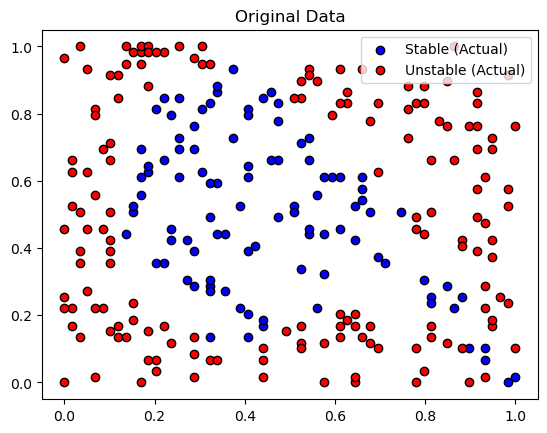

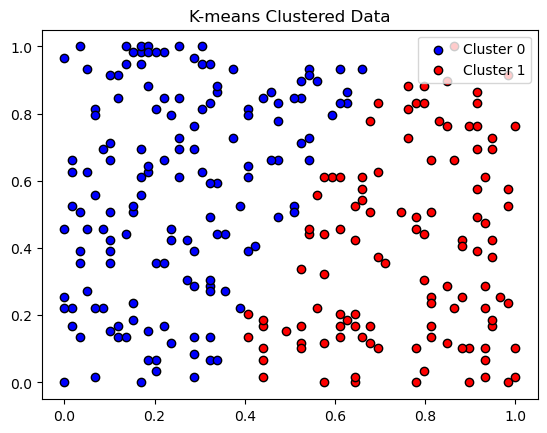

In [39]:
import matplotlib.pyplot as plt

# Assume X is your feature matrix and Y is your target variable
# Plot the original data
plt.figure()
plt.scatter(X[:, 0][Y == 1], X[:, 1][Y == 1], c="b", marker="o", ec="k", label='Stable (Actual)')
plt.scatter(X[:, 0][Y == -1], X[:, 1][Y == -1], c="r", marker="o", ec="k", label='Unstable (Actual)')
plt.title("Original Data")
plt.legend()
plt.show()

# Plot the k-means clustered data
plt.figure()
plt.scatter(X[:, 0][clusters == 1], X[:, 1][clusters == 1], c="b", marker="o", ec="k", label='Cluster 0')
plt.scatter(X[:, 0][clusters == -1], X[:, 1][clusters == -1], c="r", marker="o", ec="k", label='Cluster 1')
plt.title("K-means Clustered Data")
plt.legend()
plt.show()

# plt.figure()
# dim1 = 0
# dim2 = 1
# plt.scatter(X_norm[:, dim1][clusters == 1], X_norm[:, dim2][clusters == 1], c="b", marker="o", ec="k", label='Cluster 0')
# plt.scatter(X_norm[:, dim1][clusters == -1], X_norm[:, dim2][clusters == -1], c="r", marker="o", ec="k", label='Cluster 1')
# plt.title(f"K-means clustered normalized data (dims {dim1} and {dim2})")
# plt.show()

# plt.figure()
# dim1 = 0
# dim2 = 3
# plt.scatter(features[:, dim1][clusters == 1], features[:, dim2][clusters == 1], c="b", marker="o", ec="k", label='Cluster 0')
# plt.scatter(features[:, dim1][clusters == -1], features[:, dim2][clusters == -1], c="r", marker="o", ec="k", label='Cluster 1')
# plt.title(f"K-means clustered feature vectors (dims {dim1} and {dim2})")
# plt.show()

This time we want to generalize from the data samples. This means that
we want to train our model on one set of data and test its performance
on a second set of data that has not been used in training. To monitor
the generalization performance, the data is split into training and
validation set.


In [42]:
# K-MEANS version 
np.random.seed(0)
num_data = len(clusters)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))

# Split the features and cluster labels into training and validation sets
feats_train = features[index[:num_train]]
clusters_train = clusters[index[:num_train]]
feats_val = features[index[num_train:]]
clusters_val = clusters[index[num_train:]]

# We need these later for plotting
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]

Optimization
============

First we initialize the variables.


In [45]:
num_qubits = 2
num_layers = 6

weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

Again we minimize the cost, using the imported optimizer.


In [58]:
opt = NesterovMomentumOptimizer(0.05) # parameter = learning rate
# from pennylane.optimize import AdagradOptimizer
# opt = AdagradOptimizer(0.05)
batch_size = 128

# Train the variational classifier
weights = weights_init
bias = bias_init
for it in range(60):
    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    clusters_train_batch = clusters_train[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, feats_train_batch, clusters_train_batch)

    # Compute predictions on train and validation set
    predictions_train = np.sign(variational_classifier(weights, bias, feats_train.T))
    predictions_val = np.sign(variational_classifier(weights, bias, feats_val.T))

    # Compute accuracy on train and validation set
    acc_train = accuracy(clusters_train, predictions_train)
    acc_val = accuracy(clusters_val, predictions_val)

    if (it + 1) % 10 == 0:
        _cost = cost(weights, bias, features, clusters)
        print(
            f"Iter: {it + 1:5d} | Cost: {_cost:0.7f} | "
            f"Acc train: {acc_train:0.7f} | Acc validation: {acc_val:0.7f}"
        )

Iter:    10 | Cost: 1.1622547 | Acc train: 0.4218750 | Acc validation: 0.4687500
Iter:    20 | Cost: 0.5969909 | Acc train: 0.7812500 | Acc validation: 0.8281250
Iter:    30 | Cost: 0.3819069 | Acc train: 0.9531250 | Acc validation: 0.9531250
Iter:    40 | Cost: 0.3513538 | Acc train: 0.8958333 | Acc validation: 0.9218750
Iter:    50 | Cost: 0.3461360 | Acc train: 0.9062500 | Acc validation: 0.9218750
Iter:    60 | Cost: 0.3458149 | Acc train: 0.8958333 | Acc validation: 0.9687500


We can plot the continuous output of the variational classifier for the
first two dimensions of the Iris data set.


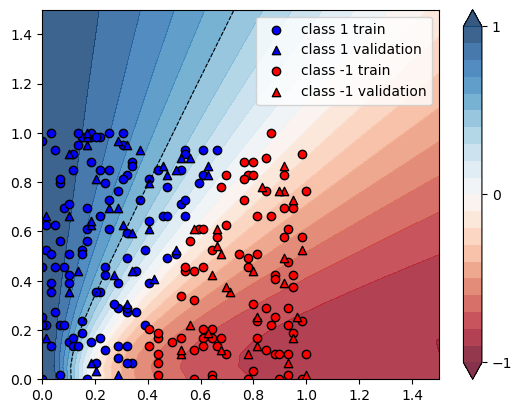

In [56]:
plt.figure()
cm = plt.cm.RdBu # Define the color map

# Generate data for decision regions
xx, yy = np.meshgrid(np.linspace(0.0, 1.5, 30), np.linspace(0.0, 1.5, 30))
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]

# Preprocess grid points like data inputs above
padding = 0.1 * np.ones((len(X_grid), 2))
X_grid = np.c_[X_grid, padding]  # Pad each input
normalization = np.sqrt(np.sum(X_grid**2, axis=-1))
X_grid = (X_grid.T / normalization).T  # Normalize each input
features_grid = np.array([get_angles(x) for x in X_grid])  # Angles are new features
predictions_grid = variational_classifier(weights, bias, features_grid.T)
Z = np.reshape(predictions_grid, xx.shape)

# Plot decision regions
levels = np.arange(-1, 1.1, 0.1)
cnt = plt.contourf(xx, yy, Z, levels=levels, cmap=cm, alpha=0.8, extend="both")
plt.contour(xx, yy, Z, levels=[0.5], colors=("black",), linestyles=("--",), linewidths=(0.8,))
plt.colorbar(cnt, ticks=[-1, 0, 1])

# Plot data
for color, label in zip(["b", "r"], [1, -1]):  # Use 1 and 0 for classes
    plot_x = X_train[:, 0][clusters_train == label]
    plot_y = X_train[:, 1][clusters_train == label]
    plt.scatter(plot_x, plot_y, c=color, marker="o", ec="k", label=f"class {label} train")
    plot_x = X_val[:, 0][clusters_val == label]
    plot_y = X_val[:, 1][clusters_val == label]
    plt.scatter(plot_x, plot_y, c=color, marker="^", ec="k", label=f"class {label} validation")

plt.legend()
plt.show()

We find that the variational classifier learnt a separating line between
the datapoints of the two different classes, which allows it to classify
even the unseen validation data with perfect accuracy.